Problem 1)

Using device: cuda

Model: RNN, Seq Length: 10, Epoch 100, Loss: 1.914288878440857, Val Loss: 2.0269858837127686, Val Acc: 43.90756%
Model: RNN, Seq Length: 10, Epoch 200, Loss: 1.363098382949829, Val Loss: 1.8690983057022095, Val Acc: 51.68067%
Model: RNN, Seq Length: 10, Epoch 300, Loss: 0.9692224264144897, Val Loss: 1.9314531087875366, Val Acc: 52.94118%
Model: RNN, Seq Length: 10, Epoch 400, Loss: 0.6992974877357483, Val Loss: 2.087959051132202, Val Acc: 51.68067%
Model: RNN, Seq Length: 10, Epoch 500, Loss: 0.496789813041687, Val Loss: 2.2936840057373047, Val Acc: 51.47059%
Model: RNN, Seq Length: 10, Time: 4.99s, Params: 44332, Model Size: 0.18MB

Model: RNN, Seq Length: 20, Epoch 100, Loss: 1.9382829666137695, Val Loss: 2.04632306098938, Val Acc: 47.25738%
Model: RNN, Seq Length: 20, Epoch 200, Loss: 1.3863131999969482, Val Loss: 1.8712300062179565, Val Acc: 49.78903%
Model: RNN, Seq Length: 20, Epoch 300, Loss: 0.9835794568061829, Val Loss: 1.9415968656539917, Val Acc: 52.10970

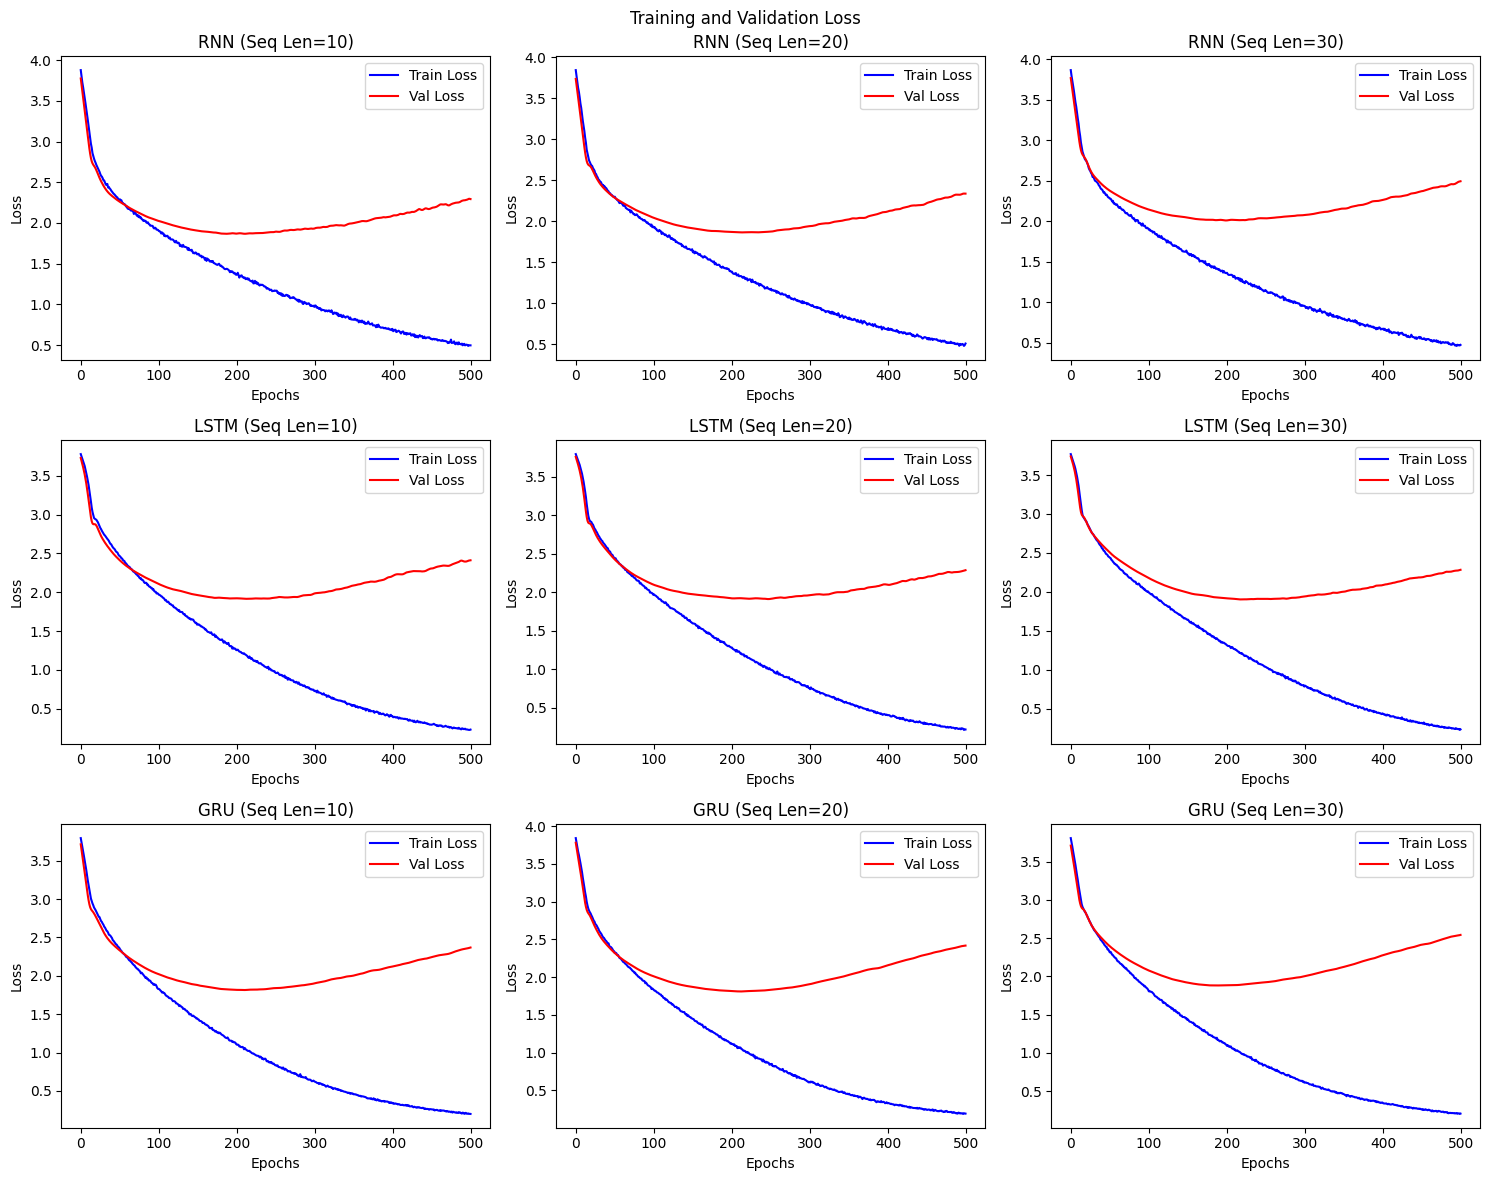

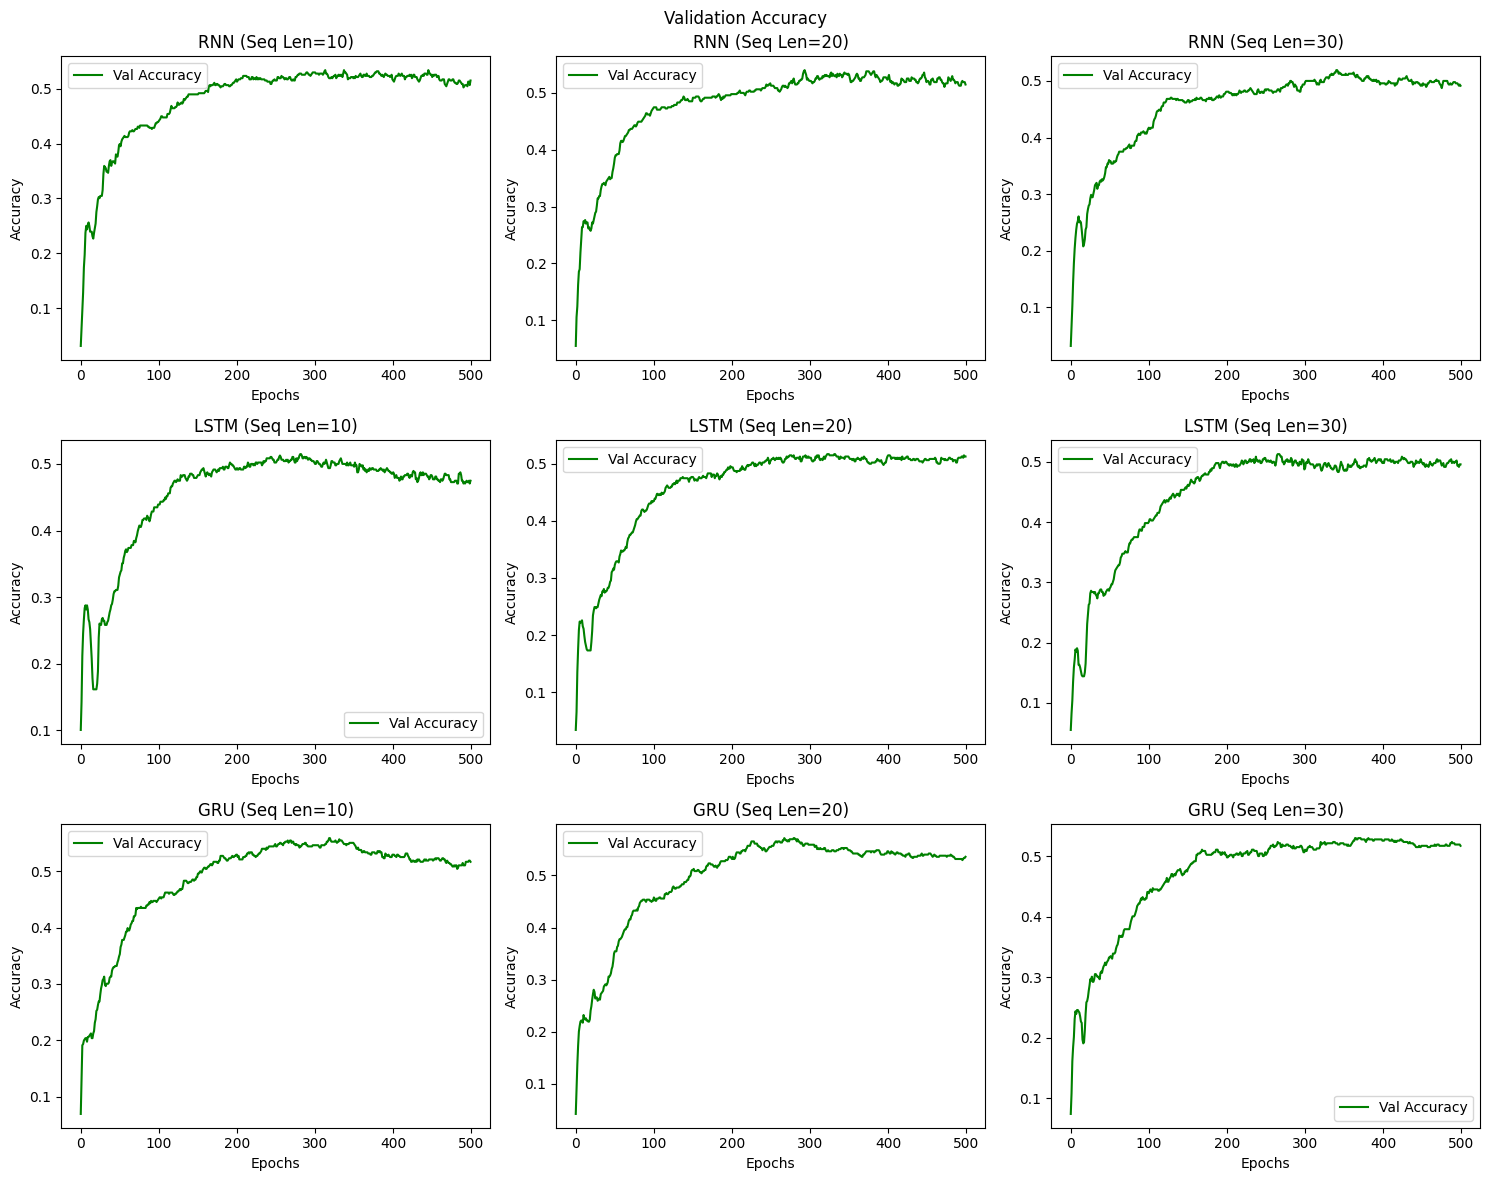

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# Sample text
text = "Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology."
chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Function to prepare dataset
def prepare_data(text, char_to_ix, sequence_length):
    X, y = [], []
    for i in range(len(text) - sequence_length):
        sequence = text[i:i + sequence_length]
        label = text[i + sequence_length]
        X.append([char_to_ix[char] for char in sequence])
        y.append(char_to_ix[label])
    return np.array(X), np.array(y)

# Model class with dropout
def create_model(model_type, input_size, hidden_size, output_size):
    class RNNModel(nn.Module):
        def __init__(self):
            super(RNNModel, self).__init__()
            self.embedding = nn.Embedding(input_size, hidden_size)
            self.dropout = nn.Dropout(0.5)  # Dropout with rate 0.5
            if model_type == 'RNN':
                self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
            elif model_type == 'LSTM':
                self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
            elif model_type == 'GRU':
                self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            embedded = self.embedding(x)
            embedded = self.dropout(embedded)  # Apply dropout after embedding
            output, _ = self.rnn(embedded)
            output = self.fc(output[:, -1, :])
            return output
    
    return RNNModel().to(device)


# Training function
def train_and_evaluate(model_type, sequence_length, hidden_size=128, learning_rate=0.001, epochs=500):
    X, y = prepare_data(text, char_to_ix, sequence_length)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val = torch.tensor(X_train, dtype=torch.long).to(device), torch.tensor(X_val, dtype=torch.long).to(device)
    y_train, y_val = torch.tensor(y_train, dtype=torch.long).to(device), torch.tensor(y_val, dtype=torch.long).to(device)
    
    model = create_model(model_type, len(chars), hidden_size, len(chars))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, val_accuracies = [], [], []
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            _, predicted = torch.max(val_output, 1)
            val_accuracy = (predicted == y_val).float().mean()
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())

        if (epoch+1) % 100 == 0:
            print(f'Model: {model_type}, Seq Length: {sequence_length}, Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Acc: {val_accuracy.item()*100:.5f}%')
    
    execution_time = time.time() - start_time
    param_count = sum(p.numel() for p in model.parameters())
    model_size = sum(p.element_size() * p.numel() for p in model.parameters()) / 1e6  # MB
    
    print("=" * 80)
    print(f'Model: {model_type}, Seq Length: {sequence_length}, Time: {execution_time:.2f}s, Params: {param_count}, Model Size: {model_size:.2f}MB')
    print("=" * 80 + "\n")
    
    return execution_time, param_count, model_size, train_losses, val_losses, val_accuracies

# Run experiments
sequence_lengths = [10, 20, 30]
model_types = ['RNN', 'LSTM', 'GRU']
results = {}

for model_type in model_types:
    for seq_len in sequence_lengths:
        results[(model_type, seq_len)] = train_and_evaluate(model_type, seq_len)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, ((model_type, seq_len), (exec_time, param_count, model_size, train_losses, val_losses, val_accuracies)) in enumerate(results.items()):
    ax1 = axes[idx]
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_title(f'{model_type} (Seq Len={seq_len})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

fig.suptitle('Training and Validation Loss')
plt.tight_layout()
plt.show()

# Plot validation accuracy
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, ((model_type, seq_len), (_, _, _, _, _, val_accuracies)) in enumerate(results.items()):
    ax2 = axes[idx]
    ax2.plot(val_accuracies, label='Val Accuracy', color='green')
    ax2.set_title(f'{model_type} (Seq Len={seq_len})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

fig.suptitle('Validation Accuracy')
plt.tight_layout()
plt.show()


Problem 2a) Tiny Shakespeare

Using device: cuda

Model: LSTM, Seq Length: 20, Epoch 5, Loss: 1.7368151010690034, Val Loss: 1.6751318899316525, Val Acc: 50.03%
Model: LSTM, Seq Length: 20, Epoch 10, Loss: 1.670503822914568, Val Loss: 1.6144477253386733, Val Acc: 51.67%
Model: LSTM, Seq Length: 20, Epoch 15, Loss: 1.6411200467704428, Val Loss: 1.5856060519677784, Val Acc: 52.37%
Model: LSTM, Seq Length: 20, Epoch 20, Loss: 1.6227434487501506, Val Loss: 1.569398137817689, Val Acc: 52.86%
Model: LSTM, Seq Length: 20, Epoch 25, Loss: 1.610669106843481, Val Loss: 1.558481217934451, Val Acc: 53.07%
Model: LSTM, Seq Length: 20, Epoch 30, Loss: 1.600640368441091, Val Loss: 1.5467953938956653, Val Acc: 53.33%
Model: LSTM, Seq Length: 20, Epoch 35, Loss: 1.5930232695649564, Val Loss: 1.541887751139632, Val Acc: 53.50%
Model: LSTM, Seq Length: 20, Epoch 40, Loss: 1.585675153490188, Val Loss: 1.5382585986218322, Val Acc: 53.54%
Model: LSTM, Seq Length: 20, Epoch 45, Loss: 1.5805325166835773, Val Loss: 1.5326723274561243, Val A

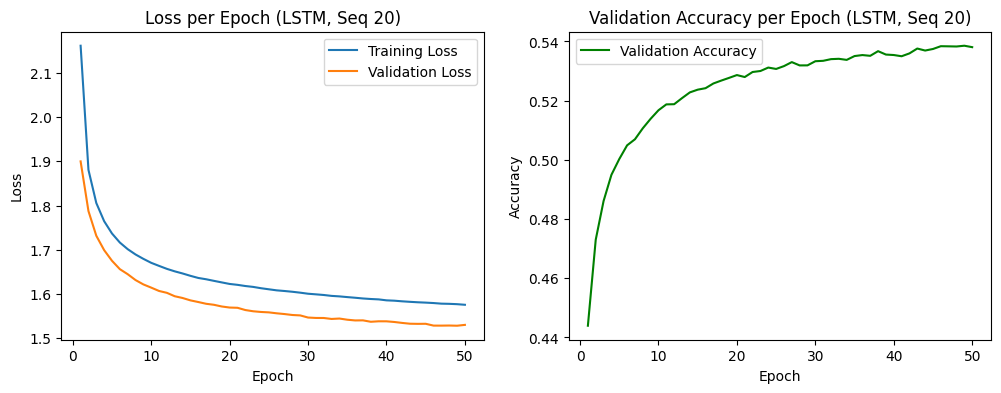

Model: LSTM, Seq Length: 30, Epoch 5, Loss: 1.7329776428652712, Val Loss: 1.6733201917158353, Val Acc: 50.11%
Model: LSTM, Seq Length: 30, Epoch 10, Loss: 1.6619656010393569, Val Loss: 1.6099285460119948, Val Acc: 51.87%
Model: LSTM, Seq Length: 30, Epoch 15, Loss: 1.6341884996244023, Val Loss: 1.5846934082037811, Val Acc: 52.51%
Model: LSTM, Seq Length: 30, Epoch 20, Loss: 1.6169964841091968, Val Loss: 1.5684448734882774, Val Acc: 52.91%
Model: LSTM, Seq Length: 30, Epoch 25, Loss: 1.6053078334631075, Val Loss: 1.5577422357207045, Val Acc: 53.19%
Model: LSTM, Seq Length: 30, Epoch 30, Loss: 1.5948663045124836, Val Loss: 1.5481943906447209, Val Acc: 53.54%
Model: LSTM, Seq Length: 30, Epoch 35, Loss: 1.5879185281467383, Val Loss: 1.5421282524636033, Val Acc: 53.66%
Model: LSTM, Seq Length: 30, Epoch 40, Loss: 1.5808266066164376, Val Loss: 1.5347289592027664, Val Acc: 53.82%
Model: LSTM, Seq Length: 30, Epoch 45, Loss: 1.5753896178627451, Val Loss: 1.532351983659858, Val Acc: 53.91%
Mod

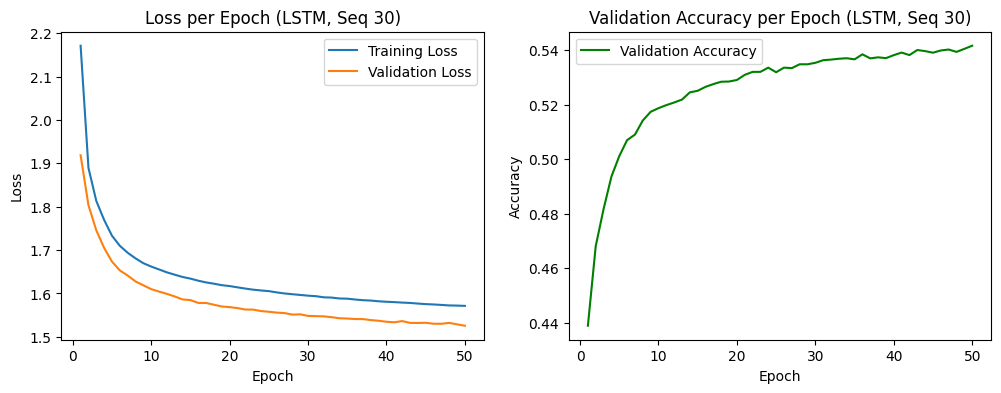

Model: GRU, Seq Length: 20, Epoch 5, Loss: 1.7330354842316196, Val Loss: 1.6784305225271698, Val Acc: 50.01%
Model: GRU, Seq Length: 20, Epoch 10, Loss: 1.6813481392972578, Val Loss: 1.6319365463125597, Val Acc: 51.37%
Model: GRU, Seq Length: 20, Epoch 15, Loss: 1.658582189475676, Val Loss: 1.6102390793758794, Val Acc: 51.88%
Model: GRU, Seq Length: 20, Epoch 20, Loss: 1.6463734558855605, Val Loss: 1.6009207724704655, Val Acc: 52.00%
Model: GRU, Seq Length: 20, Epoch 25, Loss: 1.6374718673394728, Val Loss: 1.5917060204328748, Val Acc: 52.35%
Model: GRU, Seq Length: 20, Epoch 30, Loss: 1.6302006136256255, Val Loss: 1.5854922005342782, Val Acc: 52.46%
Model: GRU, Seq Length: 20, Epoch 35, Loss: 1.6250663833992958, Val Loss: 1.582616506093139, Val Acc: 52.60%
Model: GRU, Seq Length: 20, Epoch 40, Loss: 1.6205336246350956, Val Loss: 1.5793935034526598, Val Acc: 52.62%
Model: GRU, Seq Length: 20, Epoch 45, Loss: 1.6169427043736426, Val Loss: 1.5761625392174503, Val Acc: 52.80%
Model: GRU, S

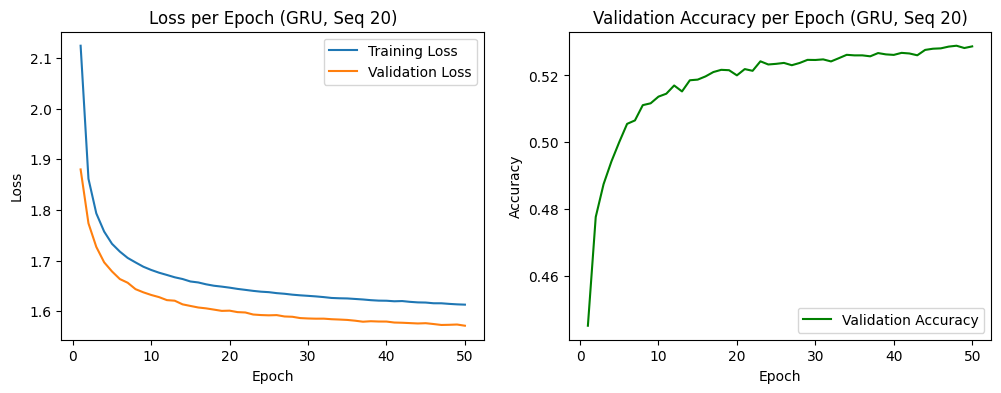

Model: GRU, Seq Length: 30, Epoch 5, Loss: 1.7289255063422986, Val Loss: 1.679519225287875, Val Acc: 50.25%
Model: GRU, Seq Length: 30, Epoch 10, Loss: 1.676244263497154, Val Loss: 1.6311080669044355, Val Acc: 51.39%
Model: GRU, Seq Length: 30, Epoch 15, Loss: 1.6534401770302842, Val Loss: 1.6112745495837764, Val Acc: 52.03%
Model: GRU, Seq Length: 30, Epoch 20, Loss: 1.6384736104594246, Val Loss: 1.5993006301855823, Val Acc: 52.31%
Model: GRU, Seq Length: 30, Epoch 25, Loss: 1.628612405769591, Val Loss: 1.5888759503397374, Val Acc: 52.53%
Model: GRU, Seq Length: 30, Epoch 30, Loss: 1.6218564720996413, Val Loss: 1.5845130054502312, Val Acc: 52.56%
Model: GRU, Seq Length: 30, Epoch 35, Loss: 1.6165097282319936, Val Loss: 1.5786265904476884, Val Acc: 52.81%
Model: GRU, Seq Length: 30, Epoch 40, Loss: 1.611701268542449, Val Loss: 1.5755555989272003, Val Acc: 52.94%
Model: GRU, Seq Length: 30, Epoch 45, Loss: 1.6076493186986247, Val Loss: 1.5704734970670227, Val Acc: 53.08%
Model: GRU, Seq

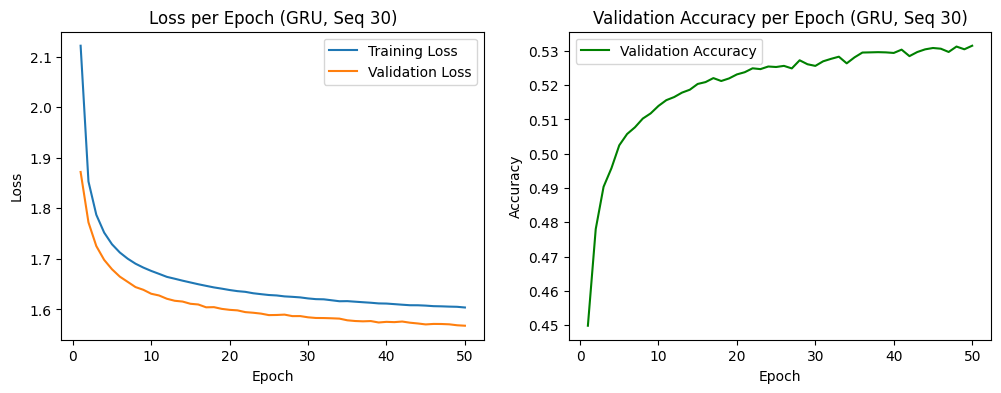

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import urllib.request
from sklearn.model_selection import train_test_split

# Check if GPU is available
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}\n")

# Define dataset URL
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filename = "tiny_shakespeare.txt"

# Download if not already present
def download_dataset(url, filename):
    if not os.path.exists(filename):
        print("Downloading Tiny Shakespeare dataset...")
        urllib.request.urlretrieve(url, filename)
        print("Download complete!")

download_dataset(url, filename)

# Load dataset
def load_text(filename):
    with open(filename, "r") as f:
        return f.read()

text = load_text(filename)

chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Function to prepare dataset
def prepare_data(text, char_to_ix, sequence_length):
    X, y = [], []
    for i in range(len(text) - sequence_length):
        sequence = text[i:i + sequence_length]
        label = text[i + sequence_length]
        X.append([char_to_ix[char] for char in sequence])
        y.append(char_to_ix[label])
    return np.array(X), np.array(y)

# Model class with dropout
def create_model(model_type, input_size, hidden_size, output_size):
    class RNNModel(nn.Module):
        def __init__(self):
            super(RNNModel, self).__init__()
            self.embedding = nn.Embedding(input_size, hidden_size)
            self.dropout = nn.Dropout(0.2)  # Dropout with rate 0.2
            if model_type == 'LSTM':
                self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
            elif model_type == 'GRU':
                self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            embedded = self.embedding(x)
            embedded = self.dropout(embedded)  # Apply dropout after embedding
            output, _ = self.rnn(embedded)
            output = self.fc(output[:, -1, :])
            return output
    
    return RNNModel().to(device)

# Training function
def train_and_evaluate(model_type, sequence_length, hidden_size=64, learning_rate=0.001, epochs=50, batch_size=256):
    X, y = prepare_data(text, char_to_ix, sequence_length)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
    y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = create_model(model_type, len(chars), hidden_size, len(chars))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, val_accuracies = [], [], []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                loss = criterion(val_output, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(val_output, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        if (epoch+1) % 5 == 0:
            print(f'Model: {model_type}, Seq Length: {sequence_length}, Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}, Val Acc: {correct / total * 100:.2f}%')
    
    execution_time = time.time() - start_time
    print("=" * 80)
    print(f'Model: {model_type}, Seq Length: {sequence_length}, Time: {execution_time:.2f}s')
    print("=" * 80 + "\n")
    
    # Plot graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch ({model_type}, Seq {sequence_length})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Accuracy per Epoch ({model_type}, Seq {sequence_length})')
    plt.legend()
    
    plt.show()
    
    return train_losses, val_losses, val_accuracies

# Run experiments
sequence_lengths = [20, 30]
model_types = ['LSTM', 'GRU']

for model_type in model_types:
    for seq_len in sequence_lengths:
        train_and_evaluate(model_type, seq_len)


Problem 2b) Tiny Shakespeare with Modeified Hyperparameters

Using device: cuda

Model: LSTM, Seq Length: 20, Epoch 5, Loss: 1.5725454793055715, Val Loss: 1.5339230815751836, Val Acc: 53.55%
Model: LSTM, Seq Length: 20, Epoch 10, Loss: 1.4940505782831557, Val Loss: 1.4692303010629952, Val Acc: 55.26%
Model: LSTM, Seq Length: 20, Epoch 15, Loss: 1.458982115084593, Val Loss: 1.4371875396015448, Val Acc: 56.21%
Model: LSTM, Seq Length: 20, Epoch 20, Loss: 1.4367931385664028, Val Loss: 1.421336635263688, Val Acc: 56.52%
Model: LSTM, Seq Length: 20, Epoch 25, Loss: 1.4225084430789783, Val Loss: 1.4109195618454469, Val Acc: 56.86%
Model: LSTM, Seq Length: 20, Epoch 30, Loss: 1.4114960856774177, Val Loss: 1.401941521998939, Val Acc: 56.97%
Model: LSTM, Seq Length: 20, Epoch 35, Loss: 1.402898293490801, Val Loss: 1.3958469060582852, Val Acc: 57.21%
Model: LSTM, Seq Length: 20, Epoch 40, Loss: 1.3951465478931018, Val Loss: 1.3914665957109644, Val Acc: 57.31%
Model: LSTM, Seq Length: 20, Epoch 45, Loss: 1.3893794989490127, Val Loss: 1.3857456429289021, Va

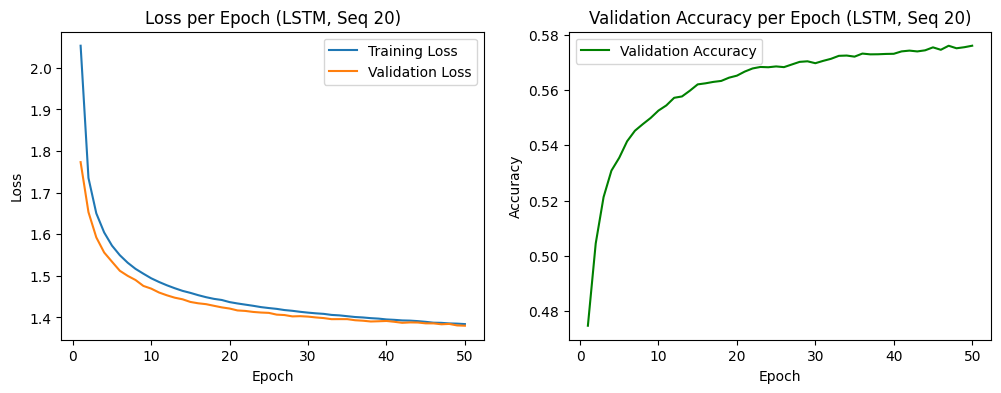

Model: LSTM, Seq Length: 30, Epoch 5, Loss: 1.5615532122599416, Val Loss: 1.5215585384893855, Val Acc: 54.11%
Model: LSTM, Seq Length: 30, Epoch 10, Loss: 1.4830895394890458, Val Loss: 1.4593382559785055, Val Acc: 55.73%
Model: LSTM, Seq Length: 30, Epoch 15, Loss: 1.4479895441681232, Val Loss: 1.4290692270348926, Val Acc: 56.48%
Model: LSTM, Seq Length: 30, Epoch 20, Loss: 1.4260837504457484, Val Loss: 1.4128799517767145, Val Acc: 56.93%
Model: LSTM, Seq Length: 30, Epoch 25, Loss: 1.4118632451597466, Val Loss: 1.399759705186984, Val Acc: 57.23%
Model: LSTM, Seq Length: 30, Epoch 30, Loss: 1.400086109759954, Val Loss: 1.3941105740879653, Val Acc: 57.53%
Model: LSTM, Seq Length: 30, Epoch 35, Loss: 1.3908059643522734, Val Loss: 1.3857336265778324, Val Acc: 57.56%
Model: LSTM, Seq Length: 30, Epoch 40, Loss: 1.3836826872565728, Val Loss: 1.3814368980740188, Val Acc: 57.85%
Model: LSTM, Seq Length: 30, Epoch 45, Loss: 1.3774086053660048, Val Loss: 1.3776444850164815, Val Acc: 57.85%
Mode

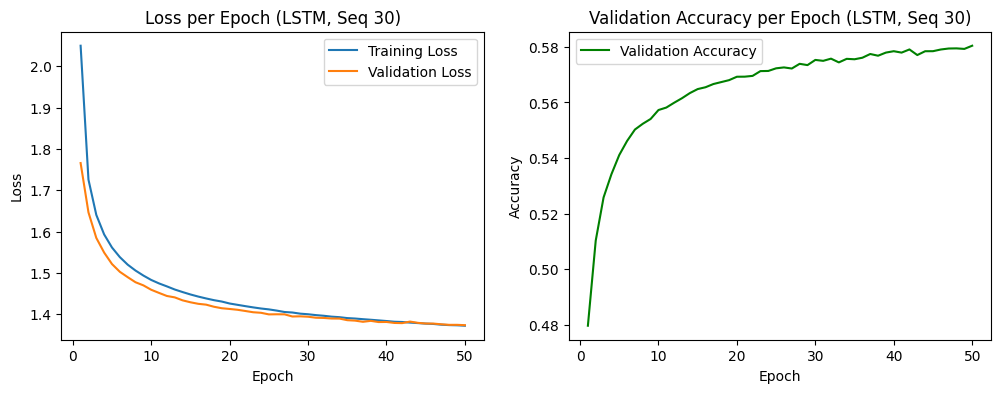

Model: GRU, Seq Length: 20, Epoch 5, Loss: 1.5528902211410864, Val Loss: 1.522240856645304, Val Acc: 54.02%
Model: GRU, Seq Length: 20, Epoch 10, Loss: 1.4916989440830426, Val Loss: 1.4706807027169324, Val Acc: 55.37%
Model: GRU, Seq Length: 20, Epoch 15, Loss: 1.4652642946577046, Val Loss: 1.453018774953457, Val Acc: 55.94%
Model: GRU, Seq Length: 20, Epoch 20, Loss: 1.4500417367384753, Val Loss: 1.4390377675721404, Val Acc: 56.19%
Model: GRU, Seq Length: 20, Epoch 25, Loss: 1.439763650152783, Val Loss: 1.431238748885076, Val Acc: 56.41%
Model: GRU, Seq Length: 20, Epoch 30, Loss: 1.4311533095983, Val Loss: 1.4235961675097089, Val Acc: 56.56%
Model: GRU, Seq Length: 20, Epoch 35, Loss: 1.4251120907099029, Val Loss: 1.4202479200625637, Val Acc: 56.57%
Model: GRU, Seq Length: 20, Epoch 40, Loss: 1.420160891950917, Val Loss: 1.419344018632119, Val Acc: 56.66%
Model: GRU, Seq Length: 20, Epoch 45, Loss: 1.4154179815718038, Val Loss: 1.416384123607513, Val Acc: 56.72%
Model: GRU, Seq Lengt

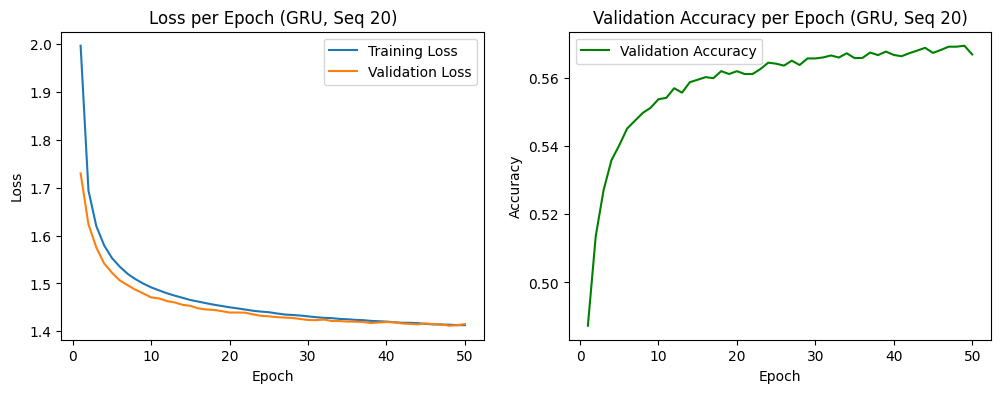

Model: GRU, Seq Length: 30, Epoch 5, Loss: 1.5457406600042793, Val Loss: 1.5154144460454992, Val Acc: 54.30%
Model: GRU, Seq Length: 30, Epoch 10, Loss: 1.482673718337006, Val Loss: 1.4676973253761956, Val Acc: 55.57%
Model: GRU, Seq Length: 30, Epoch 15, Loss: 1.454868963034209, Val Loss: 1.4448788677333693, Val Acc: 56.13%
Model: GRU, Seq Length: 30, Epoch 20, Loss: 1.4392278853737617, Val Loss: 1.432419372807949, Val Acc: 56.53%
Model: GRU, Seq Length: 30, Epoch 25, Loss: 1.4283015599417672, Val Loss: 1.424601805046064, Val Acc: 56.75%
Model: GRU, Seq Length: 30, Epoch 30, Loss: 1.4209382668761639, Val Loss: 1.4174903975714237, Val Acc: 56.90%
Model: GRU, Seq Length: 30, Epoch 35, Loss: 1.4138082020322413, Val Loss: 1.413360635895248, Val Acc: 57.07%
Model: GRU, Seq Length: 30, Epoch 40, Loss: 1.4088067456489997, Val Loss: 1.4112833459442908, Val Acc: 57.13%
Model: GRU, Seq Length: 30, Epoch 45, Loss: 1.403892571804377, Val Loss: 1.4070612941313227, Val Acc: 57.15%
Model: GRU, Seq L

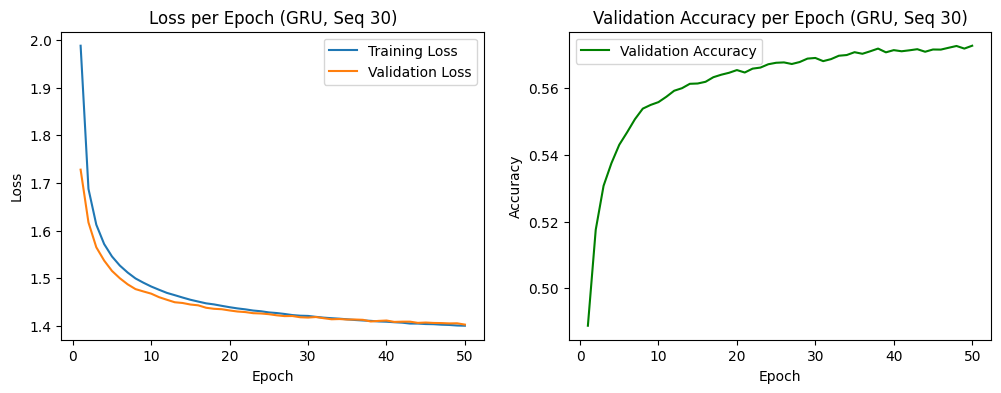

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import urllib.request
from sklearn.model_selection import train_test_split

# Check if GPU is available
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}\n")

# Define dataset URL
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filename = "tiny_shakespeare.txt"

# Download if not already present
def download_dataset(url, filename):
    if not os.path.exists(filename):
        print("Downloading Tiny Shakespeare dataset...")
        urllib.request.urlretrieve(url, filename)
        print("Download complete!")

download_dataset(url, filename)

# Load dataset
def load_text(filename):
    with open(filename, "r") as f:
        return f.read()

text = load_text(filename)

chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Function to prepare dataset
def prepare_data(text, char_to_ix, sequence_length):
    X, y = [], []
    for i in range(len(text) - sequence_length):
        sequence = text[i:i + sequence_length]
        label = text[i + sequence_length]
        X.append([char_to_ix[char] for char in sequence])
        y.append(char_to_ix[label])
    return np.array(X), np.array(y)

# Model class with dropout
def create_model(model_type, input_size, hidden_size, output_size):
    class RNNModel(nn.Module):
        def __init__(self):
            super(RNNModel, self).__init__()
            self.embedding = nn.Embedding(input_size, hidden_size)
            self.dropout = nn.Dropout(0.2)  # Dropout with rate 0.2
            if model_type == 'LSTM':
                self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
            elif model_type == 'GRU':
                self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            embedded = self.embedding(x)
            embedded = self.dropout(embedded)  # Apply dropout after embedding
            output, _ = self.rnn(embedded)
            output = self.fc(output[:, -1, :])
            return output
    
    return RNNModel().to(device)

# Training function
def train_and_evaluate(model_type, sequence_length, hidden_size=128, learning_rate=0.001, epochs=50, batch_size=512):
    X, y = prepare_data(text, char_to_ix, sequence_length)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
    y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = create_model(model_type, len(chars), hidden_size, len(chars))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, val_accuracies = [], [], []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                loss = criterion(val_output, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(val_output, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        if (epoch+1) % 5 == 0:
            print(f'Model: {model_type}, Seq Length: {sequence_length}, Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}, Val Acc: {correct / total * 100:.2f}%')
    
    execution_time = time.time() - start_time
    print("=" * 80)
    print(f'Model: {model_type}, Seq Length: {sequence_length}, Time: {execution_time:.2f}s')
    print("=" * 80 + "\n")
    
    # Plot graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch ({model_type}, Seq {sequence_length})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Accuracy per Epoch ({model_type}, Seq {sequence_length})')
    plt.legend()
    
    plt.show()
    
    return train_losses, val_losses, val_accuracies

# Run experiments
sequence_lengths = [20, 30]
model_types = ['LSTM', 'GRU']

for model_type in model_types:
    for seq_len in sequence_lengths:
        train_and_evaluate(model_type, seq_len)


Problem 2c) Tiny Shakespeare with seq_len 50

Using device: cuda

Model: LSTM, Seq Length: 50, Epoch 5, Loss: 1.548213853141185, Val Loss: 1.5159256247752304, Val Acc: 54.14%
Model: LSTM, Seq Length: 50, Epoch 10, Loss: 1.4709579409776032, Val Loss: 1.4522661506582837, Val Acc: 55.99%
Model: LSTM, Seq Length: 50, Epoch 15, Loss: 1.4363970549983398, Val Loss: 1.419168130520287, Val Acc: 56.84%
Model: LSTM, Seq Length: 50, Epoch 20, Loss: 1.4153055047687961, Val Loss: 1.4061230442939547, Val Acc: 57.25%
Model: LSTM, Seq Length: 50, Epoch 25, Loss: 1.4007311341958146, Val Loss: 1.3939714117334523, Val Acc: 57.39%
Model: LSTM, Seq Length: 50, Epoch 30, Loss: 1.3894475855091422, Val Loss: 1.3891398425495953, Val Acc: 57.56%
Model: LSTM, Seq Length: 50, Epoch 35, Loss: 1.3809245480796215, Val Loss: 1.3809516328737277, Val Acc: 57.79%
Model: LSTM, Seq Length: 50, Epoch 40, Loss: 1.3733913511362694, Val Loss: 1.3730711975228895, Val Acc: 57.96%
Model: LSTM, Seq Length: 50, Epoch 45, Loss: 1.3669975442032807, Val Loss: 1.3697809388331317, 

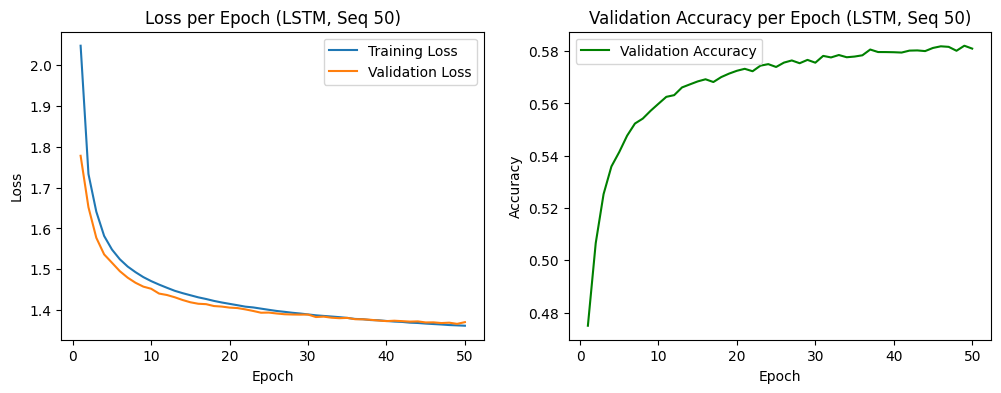

Model: GRU, Seq Length: 50, Epoch 5, Loss: 1.5356098092703456, Val Loss: 1.5045381850058879, Val Acc: 54.78%
Model: GRU, Seq Length: 50, Epoch 10, Loss: 1.4722592472277765, Val Loss: 1.455992189295795, Val Acc: 55.96%
Model: GRU, Seq Length: 50, Epoch 15, Loss: 1.4449496786278415, Val Loss: 1.4340326364980924, Val Acc: 56.55%
Model: GRU, Seq Length: 50, Epoch 20, Loss: 1.4300493778200307, Val Loss: 1.425273786170767, Val Acc: 56.78%
Model: GRU, Seq Length: 50, Epoch 25, Loss: 1.4188451643860074, Val Loss: 1.4167027292995278, Val Acc: 56.92%
Model: GRU, Seq Length: 50, Epoch 30, Loss: 1.4110488032583388, Val Loss: 1.40906421115639, Val Acc: 57.11%
Model: GRU, Seq Length: 50, Epoch 35, Loss: 1.404631266085088, Val Loss: 1.4061725399362932, Val Acc: 57.33%
Model: GRU, Seq Length: 50, Epoch 40, Loss: 1.3991694130298398, Val Loss: 1.4027568096414618, Val Acc: 57.29%
Model: GRU, Seq Length: 50, Epoch 45, Loss: 1.395069729919346, Val Loss: 1.399430084392565, Val Acc: 57.47%
Model: GRU, Seq Le

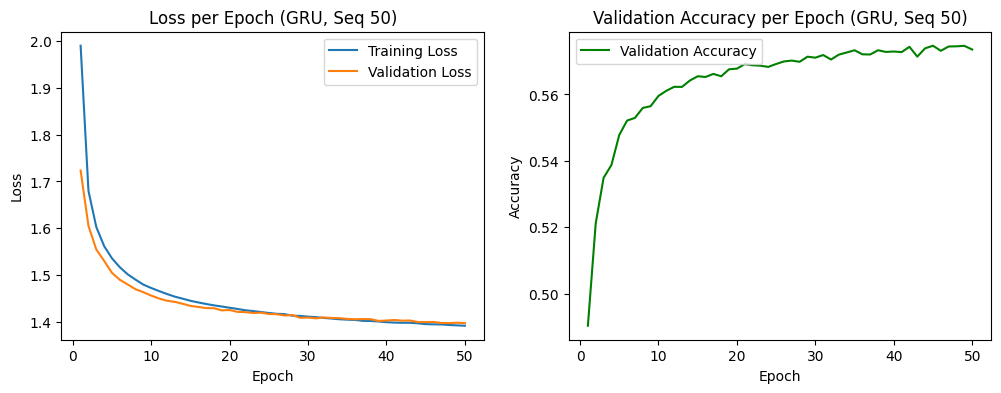

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import urllib.request
from sklearn.model_selection import train_test_split

# Check if GPU is available
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
print(f"Using device: {device}\n")

# Define dataset URL
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filename = "tiny_shakespeare.txt"

# Download if not already present
def download_dataset(url, filename):
    if not os.path.exists(filename):
        print("Downloading Tiny Shakespeare dataset...")
        urllib.request.urlretrieve(url, filename)
        print("Download complete!")

download_dataset(url, filename)

# Load dataset
def load_text(filename):
    with open(filename, "r") as f:
        return f.read()

text = load_text(filename)

chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Function to prepare dataset
def prepare_data(text, char_to_ix, sequence_length):
    X, y = [], []
    for i in range(len(text) - sequence_length):
        sequence = text[i:i + sequence_length]
        label = text[i + sequence_length]
        X.append([char_to_ix[char] for char in sequence])
        y.append(char_to_ix[label])
    return np.array(X), np.array(y)

# Model class with dropout
def create_model(model_type, input_size, hidden_size, output_size):
    class RNNModel(nn.Module):
        def __init__(self):
            super(RNNModel, self).__init__()
            self.embedding = nn.Embedding(input_size, hidden_size)
            self.dropout = nn.Dropout(0.2)  # Dropout with rate 0.1
            if model_type == 'LSTM':
                self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
            elif model_type == 'GRU':
                self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            embedded = self.embedding(x)
            embedded = self.dropout(embedded)  # Apply dropout after embedding
            output, _ = self.rnn(embedded)
            output = self.fc(output[:, -1, :])
            return output
    
    return RNNModel().to(device)

# Training function
def train_and_evaluate(model_type, sequence_length, hidden_size=128, learning_rate=0.001, epochs=50, batch_size=512):
    X, y = prepare_data(text, char_to_ix, sequence_length)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train, X_val = torch.tensor(X_train, dtype=torch.long), torch.tensor(X_val, dtype=torch.long)
    y_train, y_val = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = create_model(model_type, len(chars), hidden_size, len(chars))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, val_losses, val_accuracies = [], [], []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                loss = criterion(val_output, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(val_output, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        if (epoch+1) % 5 == 0:
            print(f'Model: {model_type}, Seq Length: {sequence_length}, Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}, Val Acc: {correct / total * 100:.2f}%')
    
    execution_time = time.time() - start_time
    print("=" * 80)
    print(f'Model: {model_type}, Seq Length: {sequence_length}, Time: {execution_time:.2f}s')
    print("=" * 80 + "\n")
    
    # Plot graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch ({model_type}, Seq {sequence_length})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Validation Accuracy per Epoch ({model_type}, Seq {sequence_length})')
    plt.legend()
    
    plt.show()
    
    return train_losses, val_losses, val_accuracies

# Run experiments
sequence_lengths = [50]
model_types = ['LSTM', 'GRU']

for model_type in model_types:
    for seq_len in sequence_lengths:
        train_and_evaluate(model_type, seq_len)


Parameter Counts for Problem 2a)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 64 
input_size = len(chars)
output_size = len(chars)

for model_type in ['LSTM', 'GRU']:
    model = create_model(model_type, input_size, hidden_size, output_size)
    num_params = count_parameters(model)
    print(f"Total trainable parameters in {model_type}: {num_params}")


Total trainable parameters in LSTM: 41665
Total trainable parameters in GRU: 33345


Parameter Counts for Problem 2a)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 128 
input_size = len(chars)
output_size = len(chars)

for model_type in ['LSTM', 'GRU']:
    model = create_model(model_type, input_size, hidden_size, output_size)
    num_params = count_parameters(model)
    print(f"Total trainable parameters in {model_type}: {num_params}")


Total trainable parameters in LSTM: 148801
Total trainable parameters in GRU: 115777
